In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

In [2]:
# import glob
# import dask.dataframe as dd
# from multiprocessing import Pool, cpu_count

# from astropy.io import fits
# from astropy.wcs import WCS

# def get_pixscale(i, other_kw=['exptime']):
#     kw_dict = {}
#     with fits.open(f'realign/{i}', mode='readonly') as f:
#         w = WCS(f[1].header, fobj=f)
#         for k in other_kw:
#             kw_dict[k] = f[0].header[k.upper()]
#     df = pd.DataFrame(index=[i], columns=['xsc', 'ysc'] + other_kw)
#     df.loc[i, ['xsc', 'ysc']] = np.abs(np.linalg.eigh(w.pixel_scale_matrix * 3600 * 1000)[0])
#     for k, v in kw_dict.items():
#         df.loc[i, k] = v
#     return df

# def read_shifts(detector, basepath='realign/shifts_?db6??'):    
#     paths = glob.glob(f'{basepath}_{detector}.txt')
#     df = dd.read_csv(paths, comment='#', delim_whitespace=True,
#                      names=['name','xshift','yshift','rot',
#                             'scale','rmsxpix','rmsypix']).compute()
#     df.sort_values(by='name', inplace=True)
#     df.set_index('name', inplace=True)
#     with Pool(cpu_count()-1) as p:
#         df_other = p.map(get_pixscale, df.index)
#     df = df.join(pd.concat(df_other))
#     df = df.assign(rmsx = df.rmsxpix * df.xsc, rmsy = df.rmsypix * df.ysc)
#     df = df.assign(rms=(df.rmsx**2 + df.rmsy**2)**0.5)
#     df = df.assign(detector=detector)
#     return df
    
# df = pd.concat([read_shifts('acs'), read_shifts('ir'), read_shifts('uvis')])
# df.to_csv('shifts_all.csv')

In [3]:
df = pd.read_csv('shifts_all.csv', index_col='name')
df.head()

,xshift,yshift,rot,scale,rmsxpix,rmsypix,xsc,ysc,exptime,rmsx,rmsy,rms,detector
name,,,,,,,,,,,,,
jdb601qzq_flc.fits,0.222488,1.998331,0.008031,1.000086,0.053350,0.064423,49.153604,52.247715,15.0,2.622345,3.365955,4.266889,acs
jdb601r2q_flc.fits,0.294840,2.040697,0.007811,1.000082,0.055966,0.059694,49.153269,52.247062,350.0,2.750912,3.118836,4.158684,acs
jdb601r5q_flc.fits,0.297336,1.954359,0.007972,1.000079,0.054990,0.068094,49.152642,52.246467,700.0,2.702904,3.557671,4.467965,acs
jdb601r9q_flc.fits,0.415606,1.980662,0.007773,1.000080,0.056230,0.060048,49.152257,52.245800,438.0,2.763831,3.137256,4.181045,acs
jdb601req_flc.fits,0.466274,2.445831,0.020614,1.000062,0.058212,0.064255,49.156334,52.250274,10.0,2.861488,3.357341,4.411333,acs


In [4]:
lim = (1,13)
hues = ['ACS/WFC','WFC3/UVIS','WFC3/IR']
#cmaps = ['Blues', 'Oranges', 'Greens']
#     sns.kdeplot(df.loc[df['Detector']==d, 'rmsx'], df.loc[df['Detector']==d, 'rmsy'],
#                 ax=g.ax_joint, legend=False, zorder=3-i, levels=5, color=pal[i],
#                 extend='both', shade=True, shade_lowest=False, alpha=0.8)

def plot_alignment_rms(df, lim, hues):
    if 'detector' in df.columns:
        df.rename({'detector':'Detector'}, axis='columns', inplace=True)
        df.replace({'Detector':{'acs':'ACS/WFC','uvis':'WFC3/UVIS','ir':'WFC3/IR'}}, inplace=True)
        df.sort_values(by='Detector', ascending=False, inplace=True)
    
    data = df.loc[df.Detector.isin(hues)]
    grid = sns.JointGrid(x='rmsx', y='rmsy', data=data, space=0, xlim=lim, ylim=lim, height=5)
    g = grid.plot_joint(sns.scatterplot, hue='Detector', data=data, hue_order=hues,
                        edgecolor=None, s=6, zorder=10, alpha=0.5)

    hist_kws = dict(range=lim, bins=25, label='__none__', density=True, alpha=0.5, zorder=-1)
    kde_kws = dict(legend=False)

    for i, d in enumerate(hues):
        df_d = df.query(f'(Detector == "{d}")')
        g.ax_marg_x.hist(df_d['rmsx'], color=pal[i], **hist_kws)
        g.ax_marg_y.hist(df_d['rmsy'], color=pal[i], orientation='horizontal', **hist_kws)
        sns.kdeplot(df_d['rmsx'], ax=g.ax_marg_x, **kde_kws)
        sns.kdeplot(df_d['rmsy'], ax=g.ax_marg_y, vertical=True, **kde_kws)

    g.ax_joint.set_xlabel('X RMS (mas)')
    g.ax_joint.set_ylabel('Y RMS (mas)')
    g.ax_joint.plot(lim, lim, color='k', alpha=0.8, lw=1, zorder=-1)

    if 'Detector' in df.columns:
        df.rename({'Detector':'detector'}, axis='columns', inplace=True)
        df.replace({'detector':{'ACS/WFC':'acs','WFC3/UVIS':'uvis','WFC3/IR':'ir'}}, inplace=True)

INFO:MainThread:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


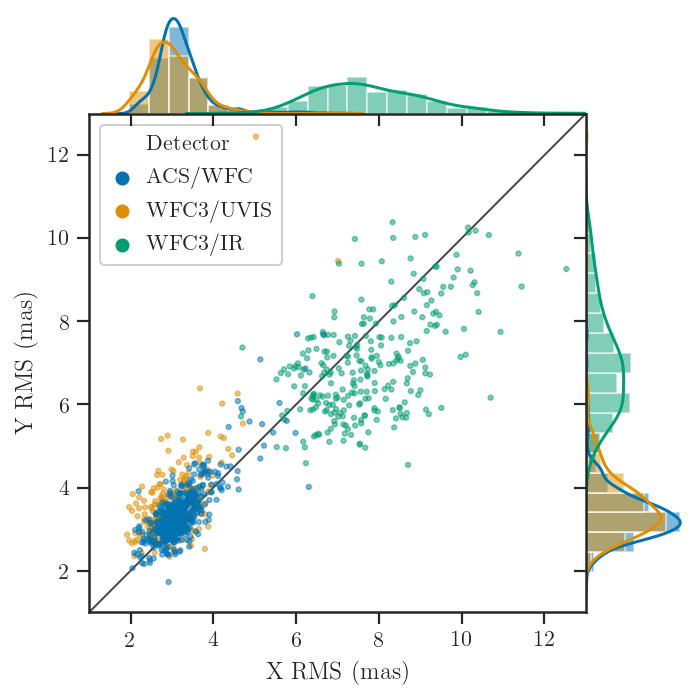

In [5]:
plot_alignment_rms(df, lim=(1, 13), hues=['ACS/WFC','WFC3/UVIS','WFC3/IR'])
plt.savefig('survey_paper_figures/alignment_all.pdf', dpi=300, bbox_inches='tight')

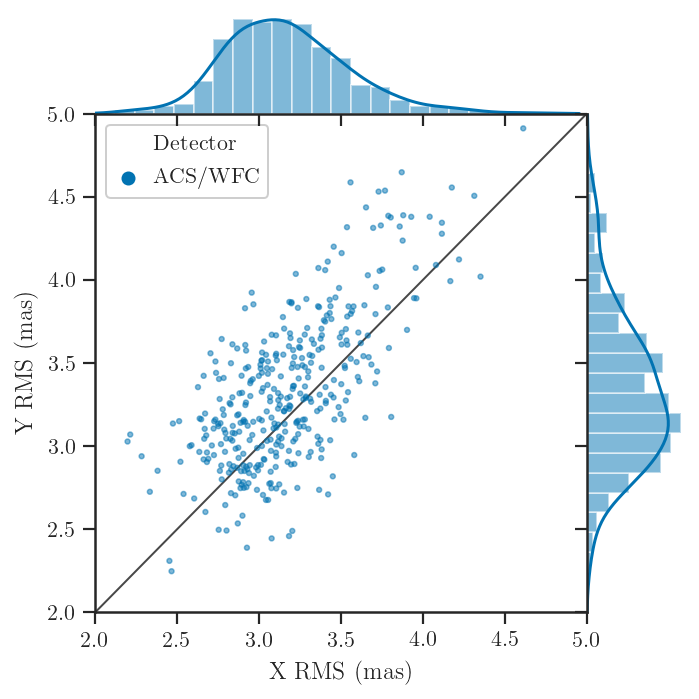

In [6]:
plot_alignment_rms(df.query('(exptime > 20)').copy(), lim=(2, 5), hues=['ACS/WFC'])
plt.savefig('survey_paper_figures/alignment_acs.pdf', dpi=300, bbox_inches='tight')